In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import squidpy as sq
import anndata as ad
import seaborn as sns
import networkx as nx
import pandas as pd

import sys
sys.path.append("../src/")
sys.path.append("/data/bionets/je30bery/truncated_graphs/src/")
from truncated_graphs import *

- create random spatial data
- connect nearest neighbors
- compute centrality scores
- for variable r, truncate graph by border r and compute centralities for everything inside, taking only nodes insight the new "window" into account
- calculate error of new and old centralities
- scatter

In [3]:
#visualize_centrality(adata_original, centrality_original['degree'], title="Degree Centrality (Original)")
#visualize_centrality(adata_truncated, centrality_truncated['degree'], title="Degree Centrality (Truncated)")

In [5]:
measure = "betweenness"
n = 1000
coordinates = generate_coordinates(n=1000, bounds=(0, 20))
adata_original = create_anndata(coordinates)
centrality_original = compute_centrality_measures(adata_original)
borders = [0, 1] #, 2, 3, 4, 5, 6, 7, 8, 9]

error_dfs = dict()
adatas_truncated = dict()
centralities_truncated = dict()

for border in borders:
    adatas_truncated[border] = filter_border_nodes(adata_original, border=border)
    centralities_truncated[border] = compute_centrality_measures(adatas_truncated[border])
    node_errors = compute_node_errors_and_distances(centrality_original, centralities_truncated[border], 
                                                    adata_original, adatas_truncated[border], 
                                                    measure=measure)
    node_errors_df = pd.DataFrame(node_errors, columns=['Node Index', 'Error', 'Distance to Closest Border'])
    error_dfs[border] = node_errors_df

In [6]:
concated_erros = pd.concat(error_dfs)

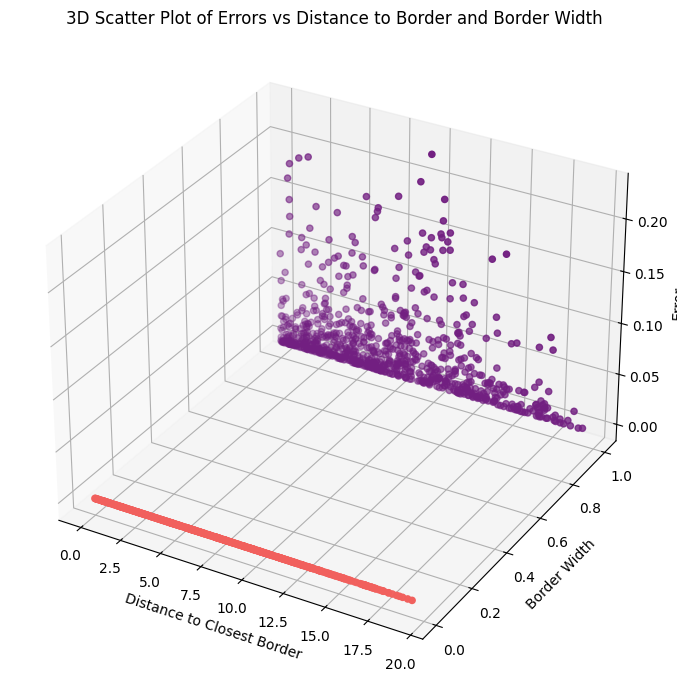

In [8]:
scatter_data = prepare_3d_scatter_data(error_dfs)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

pal = sns.color_palette("magma", len(borders))[::-1]
for i, border in enumerate(error_dfs.keys()):
    ax.scatter(error_dfs[border]['Distance to Closest Border'], [border] * len(error_dfs[border]), error_dfs[border]['Error'], 
           color=pal[i], marker='o')

ax.set_xlabel('Distance to Closest Border')
ax.set_ylabel('Border Width')
ax.set_zlabel('Error')
ax.set_title('3D Scatter Plot of Errors vs Distance to Border and Border Width')
plt.tight_layout()
#plt.savefig(f"../result_plots/{measure}.png", bbox_inches="tight")

In [9]:
def plot_graphs_with_errors(adata_original, centrality_original, adatas_truncated, centralities_truncated, error_dfs, measure=measure, border=5, bounds=(0, 20)):
    """
    Plot original and truncated graphs with node sizes based on centrality and colors based on errors.
    :param adata_original: AnnData object of the original graph
    :param centrality_original: Centrality measures from the original graph
    :param adata_truncated: AnnData object of the truncated graph
    :param centrality_truncated: Centrality measures from the truncated graph
    :param concated_erros: DataFrame containing node errors
    :param bounds: Tuple specifying the (min, max) bounds for the coordinates
    """
    # Extract original and truncated coordinates
    original_coords = adata_original.obsm['spatial']
    truncated_coords = adatas_truncated[border].obsm['spatial']
    
    # Prepare the sizes and colors for the nodes
    original_sizes = np.array(list(centrality_original[measure].values())) * 10  # Scale sizes for visibility
    truncated_sizes = np.array(list(centralities_truncated[border][measure].values())) * 10  # Scale sizes

    # Get errors for truncated graph
    errors = error_dfs[border]['Error'].values
    error_colors = np.clip(errors, 0, np.max(errors))  # Clip errors to avoid color issues

    # Create a scatter plot for original graph
    plt.figure(figsize=(10, 8))
    
    # Plot original nodes and edges
    print(original_coords.shape, len(original_sizes))
    plt.scatter(original_coords[:, 0], original_coords[:, 1], s=original_sizes, c='grey', alpha=0.6, label='Original Graph', edgecolors='k')
    # Plot truncated nodes
    print(truncated_coords.shape, len(truncated_coords))
    plt.scatter(truncated_coords[:, 0], truncated_coords[:, 1], s=truncated_sizes, c=error_colors, cmap='viridis', alpha=0.8, label='Truncated Graph', edgecolors='k')

    # Add color bar for errors
    scatter = plt.scatter([], [], c=[], cmap='viridis', alpha=0.8)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Error')
    
    # Draw rectangles for borders
    plt.gca().add_patch(plt.Rectangle((0, 0), bounds[1], bounds[1], linewidth=2, edgecolor='red', facecolor='none', label='Borders'))

    # Set axis limits and labels
    plt.xlim(-5, bounds[1] + 5)
    plt.ylim(-5, bounds[1] + 5)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Original and Truncated Graphs with Centrality and Error')
    plt.legend()
    plt.grid(True)
    
    plt.show()

(1000, 2) 1000
(903, 2) 903


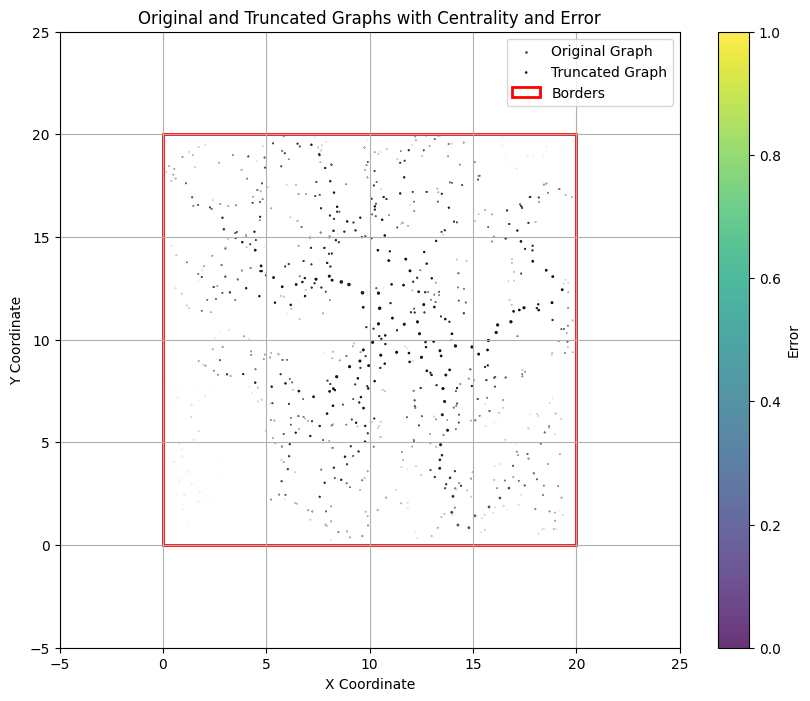

In [11]:
plot_graphs_with_errors(adata_original, centrality_original, adatas_truncated, centralities_truncated, error_dfs, border=1)

In [ ]:
node_errors_df

In [ ]:
node_errors_df